<a href="https://colab.research.google.com/github/Chuck2Win/text-generation---torchtext/blob/master/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0___by_myself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install konlpy
! pip install --upgrade torchtext
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas import DataFrame as df
import urllib.request
from konlpy.tag import Komoran
import nltk

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 2.3MB 50.5MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 1.0MB 14.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
# 네이버 영화 리뷰 데이터를 토대로 text 분류해보기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_df = pd.read_table('ratings_train.txt')
test_df = pd.read_table('ratings_test.txt')

In [3]:
# train df 150000, test df 50000
# 일단 train df 100개만 추출해서 학습을 진행해보자
train=train_df.loc[:1000][['document','label']]
train.to_csv('/content/train.csv')
train.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
os.path.realpath('ratings_train.txt')

'/content/ratings_train.txt'

In [0]:
# text 전처리
# 1.  text cleansing
train_text=train.document.str.replace('[^ㄱ-ㅎ가-힇ㅏ-ㅣ ]','')
train_label=train.label

In [0]:
from konlpy.tag import Okt
tokenizer=Okt()
train_tokenized=train_text.apply(lambda i : tokenizer.morphs(i))

In [0]:
# 2. vocab 구성하기
vocab=nltk.FreqDist(np.hstack(train_tokenized.to_numpy()))

vocab=vocab.most_common(500)

In [0]:
# 이런 방식 말고, torchtext를 활용해보자
ID=torchtext.data.Field(sequential=False, use_vocab=False)
TEXT=torchtext.data.Field(sequential=True, use_vocab=True,fix_length=30,tokenize=tokenizer.morphs,batch_first=True)
LABEL=torchtext.data.Field(sequential=False, use_vocab=False,is_target=True,batch_first=True)

In [0]:
train_data=torchtext.data.TabularDataset(path='/content/train.csv',format='csv',fields=[('id',ID),('text',TEXT),('label',LABEL)],skip_header=True)

너무 크니깐, 크기를 1000으로 줄여서 진행해보자

In [10]:
# 2. vocab 만들기 + encoding,padding까지 완료
# 2.1 정의한 Field에 .build_vocab() 하면 vocabulary 생성
TEXT.build_vocab(train_data,min_freq=0,max_size=3000)
# FIELD의 vocab.stoi를 통해서 확인가능
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f78fcb3ecc0>>, {'<unk>': 0, '<pad>': 1, '.': 2, '이': 3, '영화': 4, '의': 5, '..': 6, '가': 7, '에': 8, '...': 9, '도': 10, '들': 11, '을': 12, '는': 13, ',': 14, '은': 15, '를': 16, '?': 17, '한': 18, '다': 19, '적': 20, '진짜': 21, '정말': 22, '너무': 23, '만': 24, '!': 25, '점': 26, '연기': 27, '하고': 28, '인': 29, '최고': 30, '로': 31, '안': 32, '으로': 33, '에서': 34, '내': 35, '사람': 36, '잘': 37, '하는': 38, '....': 39, '그': 40, '보고': 41, '와': 42, '것': 43, '이다': 44, '나': 45, '본': 46, '왜': 47, '감동': 48, '과': 49, '말': 50, '못': 51, '고': 52, '재미': 53, 'ㅋㅋ': 54, '내용': 55, '생각': 56, '그냥': 57, '더': 58, '배우': 59, '아': 60, '~': 61, '드라마': 62, '시간': 63, '중': 64, '감독': 65, '스토리': 66, '없다': 67, '좀': 68, '평점': 69, '!!': 70, '게': 71, '때': 72, '쓰레기': 73, '하나': 74, '없는': 75, '이런': 76, '작품': 77, '볼': 78, '완전': 79, '요': 80, '개': 81, '또': 82, '주인공': 83, '기': 84, '지': 85, "'": 86, '1': 87, 'ㅠㅠ': 88, '거': 89, '느낌': 90, '보다': 91, '정도': 92, '듯': 93, '1

In [0]:
# torchtext의 데이터 로더 만들기
from torchtext.data import Iterator
batch_size=5
train_loader=Iterator(dataset=train_data,batch_size=batch_size)
# ?batch=next(iter(train_loader))
batch=next(iter(train_loader))

In [12]:
print('batch text')
print(batch.text.shape) # 5,30 즉 batch size, fixed len 
print(batch.text)
# print('batch label ')
# print(batch.label)

batch text
torch.Size([5, 30])
tensor([[ 117,    9,   79,  117,   39,  105, 2992,  142,  770,  785,    6,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1],
        [ 176,  107,   46,    0,  276,   64,  126,   44,   88,    3,   89,  589,
         2074, 1168,    9,    0,  714,    2,   27,   52,    0,   52,   19,  654,
         2073,  256,    0,   39,    1,    1],
        [   0,  991,   12,   96,  958,  688,  957,   13,   56,    3, 2344,   18,
            4,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1],
        [ 759,   34,  218,  246,   96, 1165, 1541,  132,    0,  208,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1],
        [1855, 2907,    0,   49,  276,  879,    6,  297,    3,  421,   61,    1,
            1,    1,    1,    1,    1,    1,    1,    1,

In [0]:
# model 만들기
class textsentiment(nn.Module):
    def __init__(self,n_vocab,n_hidden,n_class):
        super().__init__()
        self.embed=nn.Embedding(n_vocab,n_hidden,padding_idx=1)
        # self.embed.weight.requires_grad=False
        self.e2o=nn.Sequential(nn.Linear(n_hidden,n_class),nn.Sigmoid())        
    def forward(self,input_data):
        embedded=self.embed.forward(input_data)
        # embedded shape : batch size, fixed len, n_hidden
        embedded_2=embedded.mean(dim=1)
        output=self.e2o.forward(embedded_2)
        return output    


In [0]:
# train 함수 만들기
def train(batch):
    optimizer.zero_grad()
    x=batch.text.to(device)
    y=batch.label.unsqueeze(1).float().to(device)
    predict=model.forward(x)
    cost=F.binary_cross_entropy(predict,y)
    cost.backward()
    optimizer.step()
    return cost.item()


In [15]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_vocab=len(TEXT.vocab.stoi)
n_hidden=100
n_class=1
model=textsentiment(n_vocab,n_hidden,n_class).to(device)
print(list(model.parameters())[0])

Parameter containing:
tensor([[ 0.8098, -0.0841,  0.1904,  ...,  0.1377, -1.9902,  0.9660],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1113,  0.1524,  0.9274,  ..., -0.0564,  0.0063,  1.0081],
        ...,
        [-0.2842, -0.3071,  0.1966,  ..., -0.3939, -1.4574,  2.3595],
        [-0.6532, -1.6248, -0.1758,  ..., -1.2229, -0.1101, -0.2253],
        [-0.4037, -1.0803, -0.7899,  ..., -0.4610,  1.7333, -0.6586]],
       device='cuda:0', requires_grad=True)


In [16]:
cost_list=[]
optimizer=torch.optim.Adam(model.parameters())
epochs=1000
for epoch in range(epochs):
    if epoch%100==0:
        print('epoch is %d'%epoch)
    avg_cost=0
    for i,batch in enumerate(train_loader):
        cost=train(batch)
        avg_cost+=cost
    cost_list.append(avg_cost)


epoch is 0
epoch is 100
epoch is 200
epoch is 300
epoch is 400
epoch is 500
epoch is 600
epoch is 700
epoch is 800
epoch is 900


Parameter containing:
tensor([[-0.0364, -0.9214, -0.6445,  ..., -0.7171, -1.1444,  0.1045],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.7028,  1.7892,  2.4966,  ...,  1.6855, -1.5900,  2.6505],
        ...,
        [-0.2842, -0.3071,  0.1966,  ..., -0.3939, -1.4574,  2.3595],
        [-0.6532, -1.6248, -0.1758,  ..., -1.2229, -0.1101, -0.2253],
        [-0.4037, -1.0803, -0.7899,  ..., -0.4610,  1.7333, -0.6586]],
       device='cuda:0', requires_grad=True)


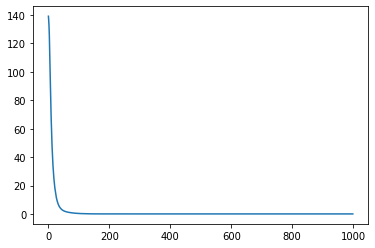

In [17]:
print(list(model.parameters())[0])
plt.plot(cost_list)

In [18]:
print(nn.Embedding(len(TEXT.vocab.stoi),100,1).forward(batch.text).shape) # 5,30,100
print(nn.Embedding(len(TEXT.vocab.stoi),100,1).forward(batch.text)[0,:,:])
print(batch.text[0])

torch.Size([1, 30, 100])
tensor([[-2.0679,  1.2185,  1.0968,  ..., -0.1476, -0.8687,  0.7316],
        [ 1.0596, -0.2809,  1.9794,  ...,  0.5794, -1.0384,  0.8304],
        [ 0.3009, -1.3943,  0.5553,  ..., -0.3076,  0.7687, -0.9720],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SliceBackward>)
tensor([   0,    3,   89,  187,   32,    0,    6,  134,   45, 1830,    6,  115,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])


In [0]:
# test 해보기
test=test_df.loc[:1000][['document','label']]
test.to_csv('test.csv')
test_data=torchtext.data.TabularDataset(path='/content/test.csv',format='csv',fields=[('id',ID),('text',TEXT),('label',LABEL)],skip_header=True)
test_loader=Iterator(dataset=test_data,batch_size=1)
with torch.no_grad():
    count=0
    count_acc=0
    for batch in test_loader:
         count+=1
         predict=model.forward(batch.text.to(device)).squeeze()>0.5
         acc=predict.long()==batch.label.to(device)
         count_acc+=acc.long().item()



In [20]:
count_acc

633

In [21]:
test

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...
996,"어색,유치. 소재는 좋았지만 결정적으로 재미가 없으니..",0
997,"디젤, 개똥폼만잡고 디아블로란 존재도 멋지지도않고",0
998,밋밋하다고밖에 할말이 없다,0
999,에로용으로도 못 쓰는 영화,0


In [22]:
# padding을 활용하고 싶지 않기 때문에, torchtext.data.Iteration으로 data loader를 만들지 말고
# torch.utils.data의 DataLoader를 활용한다.
# DataLoader는 subclasses가 있는 Dataset을 input으로 받는다
# 그래서 TensorDataset or Dataset으로 나의 dataset을 만들자
# 근데... Embedding에는 padding_idx가 있기 때문에 괜찮다 !!!
train_x=train['document'].to_numpy()
torch_x=torch.Tensor(train_x)
train_y=train['label'].to_numpy()
torch_y=torch.Tensor(train_y)
torch.utils.data.Dataset(torch_x,torch_y)

TypeError: ignored